## 🔮 Predictive Analytics — Predictive Maintenance

**Goal:** Build ML models to predict short-horizon failure and estimate RUL (what will happen). Uses the same synthetic data generation pattern as earlier notebooks.

#### 📦 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

plt.rcParams['figure.figsize']=(7,4)
pd.set_option('display.max_columns',50)

#### 📥 Read Data

In [ ]:
df = pd.read_csv('data/PdM_data.csv')

df.head()

,asset_id,age,load_factor,ambient,temperature,vibration,pressure,current,fail_next_24h,rul_hours
0,0,175.027531,1.037522,28.639848,75.772244,0.777042,32.456836,15.351275,1,112.743486
1,0,176.027531,0.792100,24.400995,74.248343,0.786263,33.293140,12.791664,0,114.756578
2,0,177.027531,0.641573,28.776035,70.731868,0.752131,30.066905,10.782674,1,127.546885
3,0,178.027531,0.638114,25.154667,68.649198,0.672473,34.409435,10.587894,1,149.582275
4,0,179.027531,0.632052,36.919182,69.473329,0.667970,32.937247,12.690585,0,130.314500


#### 🔮.1 Classification: Failure Within 24h

Accuracy: 0.825
ROC AUC: 0.744
Confusion Matrix: [[ 101  750]
 [  91 3858]]
              precision    recall  f1-score   support

           0       0.53      0.12      0.19       851
           1       0.84      0.98      0.90      3949

    accuracy                           0.82      4800
   macro avg       0.68      0.55      0.55      4800
weighted avg       0.78      0.82      0.78      4800



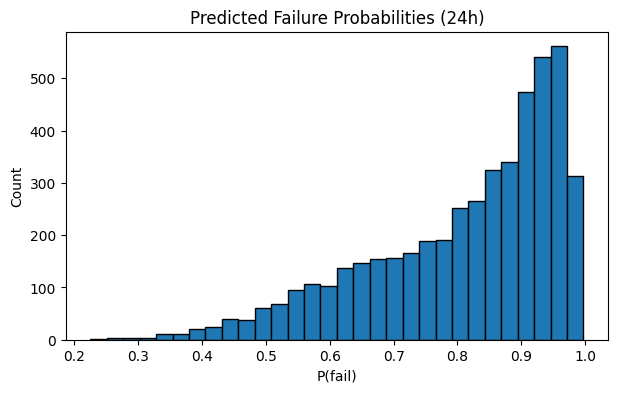

In [3]:
features=['age','load_factor','ambient','temperature','vibration','pressure','current']
X=df[features]; y=df['fail_next_24h']
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.25,random_state=518,stratify=y)
clf=Pipeline([('scaler',StandardScaler()),('rf',RandomForestClassifier(n_estimators=400,random_state=518))])
clf.fit(Xtr,ytr)
proba=clf.predict_proba(Xte)[:,1]
pred=(proba>=0.5).astype(int)
print('Accuracy:', round(accuracy_score(yte, pred), 3))
print('ROC AUC:', round(roc_auc_score(yte, proba), 3))
print('Confusion Matrix:', confusion_matrix(yte, pred))
print(classification_report(yte, pred))
plt.hist(proba,bins=30,edgecolor='black'); plt.title('Predicted Failure Probabilities (24h)'); plt.xlabel('P(fail)'); plt.ylabel('Count'); plt.show()

#### 📋 Model Performance Interpretation

- **Accuracy:** 0.825  
  The model correctly predicts failure/no-failure about 82.5% of the time on the test set.

- **ROC AUC:** 0.744  
  The model has moderate ability to distinguish between failures and non-failures (1.0 is perfect, 0.5 is random).

- **Confusion Matrix:**  
- True Negatives (TN): 101 — Correctly predicted no failure.
- False Positives (FP): 750 — Incorrectly predicted failure when there was none.
- False Negatives (FN): 91 — Missed failures.
- True Positives (TP): 3858 — Correctly predicted failures.

- **Precision, Recall, F1-score:**  
- For class 1 (failure):  
  - **Precision:** 0.84 — When the model predicts a failure, it is correct 84% of the time.
  - **Recall:** 0.98 — The model detects 98% of actual failures (very few missed).
  - **F1-score:** 0.90 — High overall balance between precision and recall.
- For class 0 (no failure):  
  - **Precision:** 0.53 — When the model predicts no failure, it is correct 53% of the time.
  - **Recall:** 0.12 — The model only identifies 12% of actual non-failures.

**Summary:**  
The model is highly sensitive to failures (very few missed), but tends to over-predict failures, resulting in many false alarms. This is common in imbalanced datasets where failures are much more frequent than non-failures. For predictive maintenance, this means most failures will be caught, but some unnecessary maintenance actions may be

#### 🔮.2 Regression: Remaining Useful Life (RUL)

MAE: 8.02 | RMSE: 10.04 | R^2: 0.716


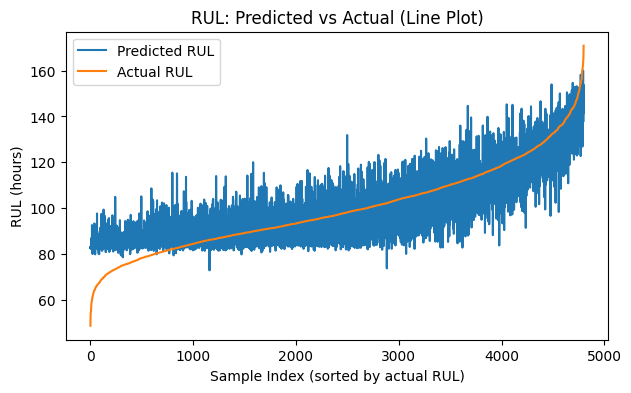

In [4]:
y_reg=df['rul_hours']
Xr_tr,Xr_te,yr_tr,yr_te=train_test_split(X,y_reg,test_size=0.25,random_state=518)
rgr=Pipeline([('scaler',StandardScaler()),('gbr',GradientBoostingRegressor(random_state=518))])
rgr.fit(Xr_tr,yr_tr)
yhat=rgr.predict(Xr_te)

mae = mean_absolute_error(yr_te, yhat)
rmse = np.sqrt(mean_squared_error(yr_te, yhat))
r2 = r2_score(yr_te, yhat)
print(f'MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}')
# Sort values for line plot
sorted_idx = np.argsort(yr_te)
plt.plot(yhat[sorted_idx], label='Predicted RUL')
plt.plot(np.array(yr_te)[sorted_idx], label='Actual RUL')
plt.title('RUL: Predicted vs Actual (Line Plot)')
plt.xlabel('Sample Index (sorted by actual RUL)')
plt.ylabel('RUL (hours)')
plt.legend()
plt.show()

#### 🧾 Takeaways
- Classification provides near-term risk.
- Regression estimates remaining life.
- These predictions feed **Prescriptive** decision rules.